# Evaluating Model Performance for Numerical Data

### Excercise: Comparing Model Performance
Load a dataset of choice, ameanible to linear regression analysis. You can use the data from the last workshop. Split the data into train - validation - and test. 

In [1]:
import os

# Change the current working directory
#os.chdir('/Users/robertocerina/Desktop/CSSci Semester IV/')

In [2]:
import pandas as pd

# load TFC data
df = pd.read_csv('./clean_TFC_data.csv')

# make the states into dummies - we will work with them as dummies from here on 
state_dummies = pd.get_dummies(df['state'], prefix='state', drop_first=True)
state_dummies = state_dummies.astype(float) 

# concatenate the dummy variables with the DataFrame
df = pd.concat([df, state_dummies], axis=1)
df = df.drop('state', axis=1)

/var/folders/_p/mgmn81xx78v22fbgp2pqhcdh0000gn/T/ipykernel_59438/943068518.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### 1a: Split your dataset into three parts, namely training, validation and test. 

In [3]:
import numpy as np

# Assuming df is your DataFrame and it has a unique identifier column named 'id'
ids = df.index.tolist()  # If 'id' is not an index, you can use df['id'].tolist()

# Shuffle the ids
np.random.seed(42)  # For reproducibility
np.random.shuffle(ids)

# Calculate split sizes
total_size = len(ids)
train_size = int(total_size * 0.5)
validation_size = int(total_size * 0.25)
# The remaining 25% will be for the test set

# Split the ids
train_ids = ids[:train_size]
validation_ids = ids[train_size:(train_size + validation_size)]
test_ids = ids[(train_size + validation_size):]

# Create the datasets based on the split ids
train_set = df.loc[train_ids]
validation_set = df.loc[validation_ids]
test_set = df.loc[test_ids]

# Now you have train_set, validation_set, and test_set

In [4]:
# Create the design matrices - add a constant to the training and validation (and test, whilst we are at it) design matrices
import statsmodels.api as sm

train_X = train_set.drop('pct_2p_vote', axis=1)
train_y = train_set['pct_2p_vote']

train_X_full = sm.add_constant( train_X )

valid_X = validation_set.drop('pct_2p_vote', axis=1)
valid_y = validation_set['pct_2p_vote']

valid_X_full = sm.add_constant( valid_X )

test_X = test_set.drop('pct_2p_vote', axis=1)
test_y = test_set['pct_2p_vote']

test_X_full = sm.add_constant( test_X )

### 1b:  Compare 3 models on their performance on the validation set

Define 3 models, one `unsaturated` which uses only the intercept; one `fully saturated` which represents the most complex model you can generate, and one in between. Fit each model to the training data, and generate predictions for each model on the test_set. 

In [5]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

def fit_predict_evaluate(train_X, train_y, valid_X, valid_y, credibility_pct=95, n_sims = 10000):
    
    # Fit the model
    model = sm.OLS(train_y, train_X).fit()
    
    # Step 2: Predict new values
    new_predictions = model.predict(valid_X)
    
    # Step 3: Calculate standard errors of the predictions
    cov_matrix = model.cov_params()
    design_matrix = valid_X
    variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
    std_errors_predictions = np.sqrt(variances)
    
    # Generate posterior samples
    new_predictions_array = np.array(new_predictions)[:, None]  
    std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  
    
    predicted_samples = np.random.normal(loc=new_predictions_array,
                                         scale=std_errors_predictions_array,
                                         size=(new_predictions.shape[0], n_sims))
    
    # Calculate estimates summaries
    monte_carlo_medians = np.median(predicted_samples, axis=1)
    prediction_intervals = np.percentile(predicted_samples, [(100-credibility_pct)/2, credibility_pct+(100-credibility_pct)/2], axis=1)
    
    # Calculate metrics
    bias = np.mean(monte_carlo_medians - valid_y)
    rmse = np.sqrt(mean_squared_error(valid_y, monte_carlo_medians))
    correlation = np.corrcoef(valid_y, monte_carlo_medians)[0, 1]
    coverage = np.mean((valid_y >=  prediction_intervals[0,:]) & (valid_y <=  prediction_intervals[1,:]))
    
    # Return results as a dictionary
    results = {
        'bias': bias,
        'rmse': rmse,
        'correlation': correlation,
        'coverage': coverage,
        'predictions': new_predictions,
        'prediction_intervals': prediction_intervals
    }

    return results

In [16]:
train_y

350    28.274495
377    43.434287
163    60.203616
609    44.845313
132    60.521391
         ...    
157    51.807311
237    50.458464
588    57.835821
175    53.978050
515    66.128221
Name: pct_2p_vote, Length: 307, dtype: float64

In [6]:
# calculate scores for each model
score_intercept_only = fit_predict_evaluate(train_X_full[['const']], train_y, valid_X_full[['const']], valid_y, credibility_pct=95) 
score_national = fit_predict_evaluate(train_X_full[['const','term2', 'real_gdp_pct_growth', 'net_approval']], train_y, valid_X_full[['const','term2', 'real_gdp_pct_growth', 'net_approval']], valid_y, credibility_pct=95) 
score_saturated = fit_predict_evaluate(train_X_full, train_y, valid_X_full, valid_y, credibility_pct=95) 

In [7]:
# generate a table with the scores 
scores = [
    {'name': 'Intercept Only', **score_intercept_only},
    {'name': 'National', **score_national},
    {'name': 'Saturated', **score_saturated},
]

# Convert the list of dictionaries to a DataFrame
scores_df_automated = pd.DataFrame(scores)

# Rename the 'name' column to 'Score Type' for clarity
scores_df_automated.rename(columns={'name': 'Score Type'}, inplace=True)

scores_df_automated

,Score Type,bias,rmse,correlation,coverage,predictions,prediction_intervals
0,Intercept Only,-1.760921,11.843099,-0.251109,0.084967,506 50.070954 194 50.070954 517 50.07...,"[[48.822550241354534, 48.83105978214468, 48.84..."
1,National,-1.264394,11.181083,0.320943,0.209150,506 51.403064 194 50.553021 517 48.56...,"[[49.698186440962864, 48.57592378033994, 45.97..."
2,Saturated,-0.371120,12.506045,0.042352,0.640523,506 52.976054 194 47.112437 517 49.60...,"[[41.67335307626104, 37.53446635746642, 41.773..."


### 1c:  Comment on the scores

Can you identify a model to move forward with ? on what grounds ? 
What do the differences in performance over the different metrics tell you about each model's strengths and weaknesses ? 

In [8]:
train_X_full

,const,year,term2,real_gdp_pct_growth,net_approval,state_ALASKA,state_ARIZONA,state_ARKANSAS,state_CALIFORNIA,state_COLORADO,...,state_SOUTH DAKOTA,state_TENNESSEE,state_TEXAS,state_UTAH,state_VERMONT,state_VIRGINIA,state_WASHINGTON,state_WEST VIRGINIA,state_WISCONSIN,state_WYOMING
350,1.0,2000,0,4.1,19,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
377,1.0,2004,1,3.8,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163,1.0,1988,0,4.2,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
609,1.0,2020,1,-2.2,-6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
132,1.0,1984,1,7.2,25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.0,1988,0,4.2,13,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
237,1.0,1992,0,3.5,-22,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,1.0,2020,1,-2.2,-6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,1.0,1988,0,4.2,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1d: For your best performning model, estimate the generalisation error 

Generate point-estimates and a measure of uncertainty for each error metric. Hint: the most comprehensive way to do this is to generate error distributions. You can do this by calculating each error metric on a separate set of simulated predictions from the empirical predictive posterior distribution. 

In [9]:
# Fit the model (best performing was National on the RMSE metric)
model = sm.OLS(train_y, train_X_full[['const','term2', 'real_gdp_pct_growth', 'net_approval']]).fit()
    
# Step 2: Predict new values
new_predictions = model.predict(valid_X_full[['const','term2', 'real_gdp_pct_growth', 'net_approval']])
    
# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = valid_X_full[['const','term2', 'real_gdp_pct_growth', 'net_approval']]
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)
    
# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None]  
std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  
    
predicted_samples = np.random.normal(loc=new_predictions_array,
                                     scale=std_errors_predictions_array,
                                     size=(new_predictions.shape[0], 1000)) 

In [10]:
# Calculate metrics
bias_array = np.mean(predicted_samples - valid_y.values[:,None], axis=0)
rmse_array = np.sqrt(np.mean((predicted_samples - valid_y.values[:,None])**2, axis=0))
correlation_array = np.array([np.corrcoef(valid_y.values[:,None], pred, rowvar=False)[0, 1] for pred in predicted_samples.T])
# Note: coverage doesn't have a distribution, because it is already a measure which is averaged over simulations. So it is omitted here - we know it from the table above. 
# Combine metrics into a single array where each metric is a column
metrics = {
    'Bias': bias_array,
    'RMSE': rmse_array,
    'Correlation': correlation_array
}


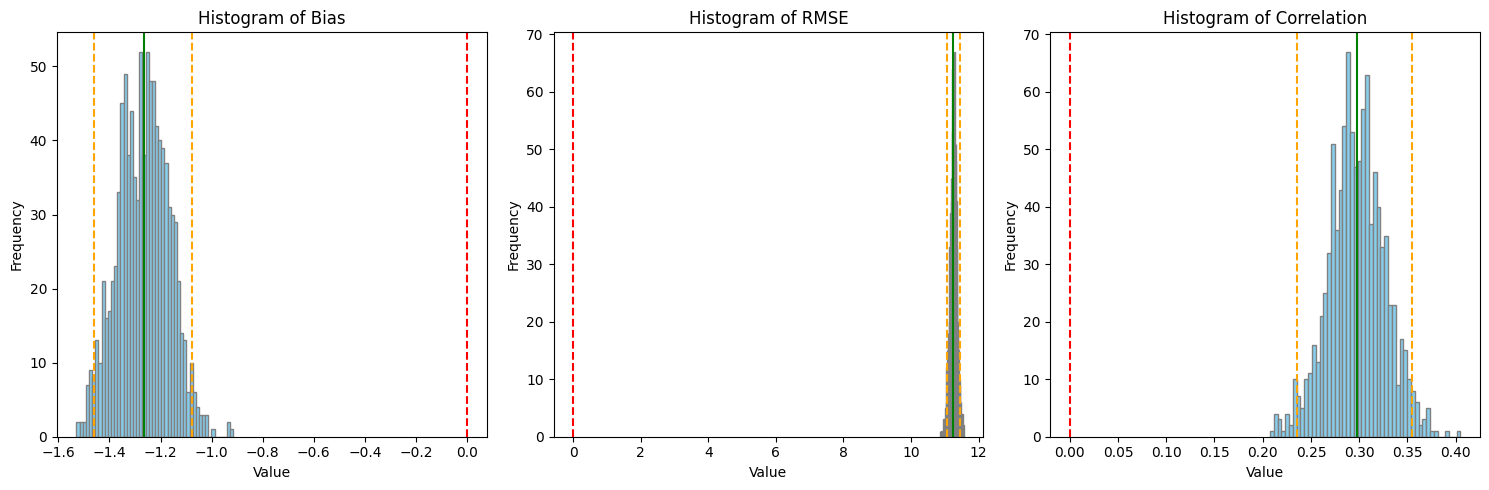

In [11]:
# plot the distributions of each error metric
import matplotlib.pyplot as plt

# Define metric names
metric_names = ['Bias', 'RMSE', 'Correlation']

# Define number of metrics to plot
n_metrics = len(metric_names)

# Adjust rows and columns calculation to avoid empty subplots
n_plots = n_metrics  # Total number of plots needed
n_rows = 1
n_cols = (n_plots + n_rows - 1) // n_rows  # Calculate columns needed, ensuring we have enough space

# Adjust the figsize if necessary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), squeeze=False)  # Make sure axes is always a 2D array

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i, name in enumerate(metric_names):
    data = metrics[name]  # Access data directly from dictionary
    median_val = np.median(data)
    confidence_interval = np.percentile(data, [2.5, 97.5])
    
    ax = axes_flat[i]
    ax.hist(data, bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--', label='Zero line')  # Highlight 0 with a line
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Ensure plot encompasses 0 by adjusting xlim if necessary
    xlims = ax.get_xlim()
    ax.set_xlim(min(xlims[0], 0), max(xlims[1], 0))

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes_flat[j])

# Adjust layout for better spacing and display the plot
plt.tight_layout()
plt.show()